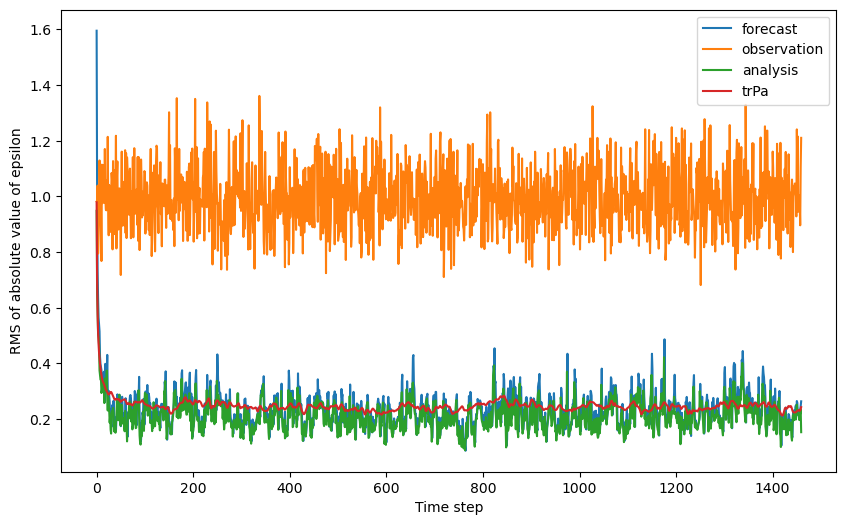

In [1]:
#Pa = a**2*Iに変える
import pandas as pd
import numpy as np
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import sys
import matplotlib.pyplot as plt

F = 8.0
N = 40
dt = 0.05
days = 365
day_steps = int(0.20 / dt)  
time_step = days * day_steps
delta = 0.001
ls_time_step = [i for i in range(time_step)]
tuning = 1.1

def L96(x):
    dxdt = np.zeros((N))
    for i in range(2, N-1):
        dxdt[i] = (x[i+1]-x[i-2])*x[i-1] - x[i] + F

    dxdt[0] = (x[1]-x[N-2])*x[N-1] - x[0] + F
    dxdt[1] = (x[2]-x[N-1])*x[0] - x[1] + F
    dxdt[N-1] = (x[0]-x[N-3])*x[N-2] - x[N-1] + F
    return dxdt    

def Rk4(xold):
    k1 = L96(xold)
    k2 = L96(xold + k1 * dt / 2.)
    k3 = L96(xold + k2 * dt / 2.)
    k4 = L96(xold + k3 * dt)
    xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xnew

#Root-Mean-Square
def RMS(error):
    return np.sqrt(np.mean(error**2))
def trRMS(x):
    return np.sqrt(x / N)

def main():
    df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
    x_true = df_x_true.values
    df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
    y = df_y.values
    #ヤコビ行列での計算で使う
    IN = np.eye(N)
    #観測演算子(今回は y : 40変数、x : 40変数)
    #仮
    H = np.eye(N)
    #観測誤差共分散行列(標準正規分布に従う乱数を真値に足して観測データとした)
    #仮
    R = np.eye(N)
    #初期設定
    #仮(真値と１ステップだけずらした)
    #Xa0とする。
    x_a = x_true[1,:]
    epsilon_a = x_a - x_true[0,:]
    #解析誤差共分散行列
    #a = 5と仮定
    Pa = 25 * np.eye(N)
    #モニター用の配列
    #予報
    forecast = []
    #解析
    analysis = []
    trPa = []
    #誤差
    error_f = []
    error_a = []
    error_o = []
    for i in range(time_step):
        x_f = Rk4(x_a)
        forecast.append(x_f)
        JM = np.zeros((N, N))
        for j in range(N):
            JM[:, j] = (Rk4(x_a + delta * IN[:,j]) - Rk4(x_a)) / delta

        Pf = tuning * JM @ Pa @ JM.T
        K = Pf @ H.T @ np.linalg.pinv(H @ Pf @ H.T + R)
        x_a = x_f + K @ (y[i, :] - H @ x_f)
        analysis.append(x_a)
        Pa = (eye(N) - K @ H) @ Pf
        trPa.append(trRMS(np.trace(Pa)))
    forecast = np.array(forecast)
    analysis = np.array(analysis)
    trPa = np.array(trPa)

    for i in range(time_step):
        f = forecast[i, :]
        a = analysis[i, :]
        o = y[i, :]
        t = x_true[i, :]
        epsilon_f = f - t
        error_f.append(RMS(epsilon_f))
        epsilon_a = a - t
        error_a.append(RMS(epsilon_a))
        epsilon_o = o - t
        error_o.append(RMS(epsilon_o))
        
    plt.figure(figsize=(10, 6))
    plt.xlabel('Time step')
    plt.ylabel('RMS of absolute value of epsilon')
    plt.plot(ls_time_step, error_f, label='forecast')
    plt.plot(ls_time_step, error_o, label='observation')
    plt.plot(ls_time_step, error_a, label='analysis')
    plt.plot(ls_time_step, trPa, label='trPa')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Mean RMS Error: 5.194572224562966


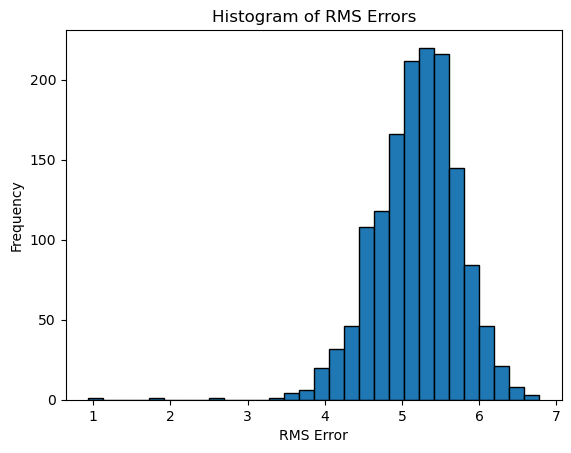

In [5]:
import pandas as pd
import numpy as np
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import sys
import matplotlib.pyplot as plt

F = 8.0
N = 40
dt = 0.05
days = 365
day_steps = int(0.20 / dt)  
time_step = days * day_steps + 1
delta = 1.0e-5
ls_time_step = [i for i in range(time_step)]

def L96(x):
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

def Rk4(xold):
    k1 = L96(xold)
    k2 = L96(xold + k1 * dt / 2.)
    k3 = L96(xold + k2 * dt / 2.)
    k4 = L96(xold + k3 * dt)
    xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xnew

#Root-Mean-Square
def RMS(error):
    RSS = 0
    for i in range(len(error)):
        RSS += error[i]**2
    return np.sqrt(RSS/len(error))

def main():
    df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
    x_true = df_x_true.values
    df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
    y = df_y.values
    #ヤコビ行列での計算で使う
    IN = np.eye(N)
    #観測演算子(今回は y : 40変数、x : 40変数)
    #仮
    H = np.eye(N)
    #観測誤差共分散行列(標準正規分布に従う乱数を真値に足して観測データとした)
    #仮
    R = np.eye(N)
    Epsilon_a = []
    for i in range(1,1460):
        x_a = x_true[i,:]
        epsilon_a = x_a - x_true[0,:]
        Epsilon_a.append(RMS(epsilon_a))
        
    # Convert to NumPy array for plotting
    Epsilon_a = np.array(Epsilon_a)
    
    # Print mean RMS error
    print("Mean RMS Error:", np.mean(Epsilon_a))
    
    # Plot histogram
    plt.hist(Epsilon_a, bins=30, edgecolor='k')
    plt.xlabel('RMS Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMS Errors')
    plt.show()
    
if __name__ == "__main__":
    main()